# Import Libraries 

In [ ]:
!pip install spectral  
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 212 kB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from keras.regularizers import l2
import pandas as pd
import numpy as np
from tensorflow import  keras
from tensorflow.keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from tensorflow.keras.layers import Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam # - Works
from tensorflow.keras.callbacks import ModelCheckpoint
#from tensorflow.keras.utils import utils #np_utils
from tensorflow.keras.utils import to_categorical

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os

import tensorflow as tf
init_notebook_mode(connected=True)
%matplotlib inline

import spectral.io.envi as envi
from spectral import*
import matplotlib.pyplot as plt
import spectral

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [ ]:
# function that gets the reflectance from intensities 
 
def get_reflectance(image):
  reflectance=np.zeros((image.shape))
  depth=image.shape[2]
  for lamda in range(depth):
    image_layer=image[:,:,lamda]
    radiance=image_layer.mean()
    reflectance[:,:,lamda]=image_layer.reshape(image.shape[:2])/radiance

  return reflectance


In [ ]:
def change_2_triple_input(img_refl):
  # input image 
  img_refl.shape
  # pad image 
  img_refl_padded=np.zeros(  ( img_refl.shape[0] , img_refl.shape[1] + 2       ,  img_refl.shape[2]       ) )
  # create a bigger 
  # fill the inside 
  img_refl_padded[ : , 1:img_refl.shape[1] + 1 ,: ]= img_refl 
  #change to input size triple in each row
  img_refl_input=np.zeros( (img_refl_padded.shape[0]*(img_refl_padded.shape[1]-2),img_refl_padded.shape[2]*3) )
  counter=0
  for row in range(img_refl_padded.shape[0]): 
    for col in range( 1 , img_refl_padded.shape[1]- 1 ):   
      img_refl_input[counter,:] = img_refl_padded[row,col-1:col+2,:].reshape(1,img_refl_padded.shape[2]*3) # double check this step 
      counter=counter + 1;
  return img_refl_input


In [ ]:
def form_label_matrix(img,img_string,df,draw):


  label_matrix_img=np.zeros(img.shape[:2])

  img_labeled=df.loc[img_string,["x","y","label"]]


  ## level one 
  i=0
  img_index_1=np.where(img_labeled["label"] == 'Level 1')

  img_labeled_1=img_labeled[["x","y"]].iloc[ img_index_1[0].tolist() ]

  img_labeled_1_x=img_labeled_1["x"].tolist()
  img_labeled_1_y=img_labeled_1["y"].tolist()

  for i in range(len(img_labeled_1_x)):
    x=int(img_labeled_1_x[i])
    y=int(img_labeled_1_y[i])
    label_matrix_img[y][x]=1

  ## level 3 
  i=0
  img_index_3=np.where(img_labeled["label"] == 'Level 3')

  img_labeled_3=img_labeled[["x","y"]].iloc[ img_index_3[0].tolist() ]

  img_labeled_3_x=img_labeled_3["x"].tolist()
  img_labeled_3_y=img_labeled_3["y"].tolist()

  for i in range(len(img_labeled_3_x)):
    x=int(img_labeled_3_x[i])
    y=int(img_labeled_3_y[i])
    label_matrix_img[y][x]=2

  ## level 4 
  i=0

  img_index_4=np.where(img_labeled["label"] == 'Level 4')  

  img_labeled_4=img_labeled[["x","y"]].iloc[ img_index_4[0].tolist() ]

  img_labeled_4_x=img_labeled_4["x"].tolist()
  img_labeled_4_y=img_labeled_4["y"].tolist()

  for i in range(len(img_labeled_4_x)):
    x=int(img_labeled_4_x[i])
    y=int(img_labeled_4_y[i])
    label_matrix_img[y][x] = 3 



  ## background 
  i=0 

  img_index_b=np.where(img_labeled["label"] == 'background') 

  img_labeled_b=img_labeled[["x","y"]].iloc[ img_index_b[0].tolist() ]

  img_labeled_b_x=img_labeled_b["x"].tolist()
  img_labeled_b_y=img_labeled_b["y"].tolist()

  for i in range(len(img_labeled_b_x)):
    x=int(img_labeled_b_x[i])
    y=int(img_labeled_b_y[i])
    label_matrix_img[y][x]=4 


  #draw

  # not labeled , 1, 3, 4 , b
  # black , blue , light blue , yellow, red
  if draw == 1:
    paint_cmap = ListedColormap(['#000000','#0000CD', '#00FFFF', '#FFFF00', '#FF0000'], name='Level')

    plt.imshow(label_matrix_img , cmap=paint_cmap) #paint_cmap


  return  label_matrix_img
    

In [ ]:
#split data
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test


In [ ]:
def predict_image(img_short,draw):
  # get reflectance 
  reflectance_short=get_reflectance(img_short)
  input_short=change_2_triple_input(reflectance_short)
  


  # predict short 
  predictions_short = model_short.predict(  #### my mistake was here , I put model rather than model short
        #x=scaled_samples_withoutzero
        x=input_short      
      , batch_size=1000 # what is the defualt
      , verbose=0
  )  

  rounded_predictions_short = np.argmax(predictions_short, axis=-1) #review the axis

  y_short_predicted=rounded_predictions_short.reshape(img_short.shape[:2]) #check if correct 

 # if draw == 1:
    # blue , light blue , yellow, red
    #paint_cmap = ListedColormap(['#0000CD', '#00FFFF', '#FFFF00', '#FF0000'], name='Level')

    #plt.imshow(y_short_predicted, cmap=paint_cmap) #paint_cmap

    #view4 = imshow(img_short, (1, 6, 20),figsize =(7,7))

  if draw == 1:
    # green orange red gray 
      paint_cmap = ListedColormap([   '#AAF803' ,'#F89403', '#FC240A','#000000'], name='Level')


      # just a trick
      y_short_predicted_temp = y_short_predicted
      y_short_predicted_temp[0,0]=1
      y_short_predicted_temp[0,1]=2
      y_short_predicted_temp[0,2]=3
      y_short_predicted_temp[0,5]=0

      plt.imshow(y_short_predicted_temp, cmap=paint_cmap) #paint_cmap

      view4 = imshow(img_short, (1, 6, 20),figsize =(7,7))



# Input

In [ ]:
# get full image 
Level4_1_img= envi.open('/content/drive/MyDrive/sydney_data/images/Level4-1.hdr','/content/drive/MyDrive/sydney_data/images/Level4-1.fla')
Level4_2_img= envi.open('/content/drive/MyDrive/sydney_data/images/Level4-2.hdr','/content/drive/MyDrive/sydney_data/images/Level4-2.fla')
Level4_3_img= envi.open('/content/drive/MyDrive/sydney_data/images/Level4-3.hdr','/content/drive/MyDrive/sydney_data/images/Level4-3.fla')
Level4_4_img= envi.open('/content/drive/MyDrive/sydney_data/images/Level4-4.hdr','/content/drive/MyDrive/sydney_data/images/Level4-4.fla')
Level4_5_img= envi.open('/content/drive/MyDrive/sydney_data/images/Level4-5.hdr','/content/drive/MyDrive/sydney_data/images/Level4-5.fla')
Level4_6_img= envi.open('/content/drive/MyDrive/sydney_data/images/Level4-6.hdr','/content/drive/MyDrive/sydney_data/images/Level4-6.fla')
Level4_7_img= envi.open('/content/drive/MyDrive/sydney_data/images/Level4-7.hdr','/content/drive/MyDrive/sydney_data/images/Level4-7.fla')
Level4_8_img= envi.open('/content/drive/MyDrive/sydney_data/images/Level4-8.hdr','/content/drive/MyDrive/sydney_data/images/Level4-8.fla')
Level4_9_img= envi.open('/content/drive/MyDrive/sydney_data/images/Level4-9.hdr','/content/drive/MyDrive/sydney_data/images/Level4-9.fla')
Level4_10_img= envi.open('/content/drive/MyDrive/sydney_data/images/Level4-10.hdr','/content/drive/MyDrive/sydney_data/images/Level4-10.fla')

Peeling_1_img= envi.open('/content/drive/MyDrive/sydney_data/images/Peeling-1.hdr','/content/drive/MyDrive/sydney_data/images/Peeling-1.fla')
Peeling_2_img= envi.open('/content/drive/MyDrive/sydney_data/images/Peeling-2.hdr','/content/drive/MyDrive/sydney_data/images/Peeling-2.fla')

Peeling_4_img= envi.open('/content/drive/MyDrive/sydney_data/images/Peeling-4.hdr','/content/drive/MyDrive/sydney_data/images/Peeling-4.fla')
# get full reflectance image 

In [ ]:
# get full reflectance image 
Level4_1_img_refl=get_reflectance(Level4_1_img)
Level4_2_img_refl=get_reflectance(Level4_2_img)
Level4_3_img_refl=get_reflectance(Level4_3_img)
Level4_4_img_refl=get_reflectance(Level4_4_img)
Level4_5_img_refl=get_reflectance(Level4_5_img)
Level4_6_img_refl=get_reflectance(Level4_6_img)
Level4_7_img_refl=get_reflectance(Level4_7_img)
Level4_8_img_refl=get_reflectance(Level4_8_img)
Level4_9_img_refl=get_reflectance(Level4_9_img)
Level4_10_img_refl=get_reflectance(Level4_10_img)

Peeling_1_img_refl=get_reflectance(Peeling_1_img)
Peeling_2_img_refl=get_reflectance(Peeling_2_img)

Peeling_4_img_refl=get_reflectance(Peeling_4_img)

# flat the reflectance image 
#Level4_1_img_refl_flat=Level4_1_img_refl.reshape( (  Level4_1_img_refl.shape[0]*Level4_1_img_refl.shape[1] , Level4_1_img_refl.shape[2]) )


In [ ]:
# change to input shape of triples

Level4_1_img_refl_input=change_2_triple_input(Level4_1_img_refl)
Level4_3_img_refl_input=change_2_triple_input(Level4_3_img_refl)
Level4_4_img_refl_input=change_2_triple_input(Level4_4_img_refl)
Level4_5_img_refl_input=change_2_triple_input(Level4_5_img_refl)
Level4_6_img_refl_input=change_2_triple_input(Level4_6_img_refl)
Level4_7_img_refl_input=change_2_triple_input(Level4_7_img_refl)
Level4_8_img_refl_input=change_2_triple_input(Level4_8_img_refl)
Level4_9_img_refl_input=change_2_triple_input(Level4_9_img_refl)
Level4_10_img_refl_input=change_2_triple_input(Level4_10_img_refl)

Peeling_1_img_refl_input=change_2_triple_input(Peeling_1_img_refl)
Peeling_2_img_refl_input=change_2_triple_input(Peeling_2_img_refl)

Peeling_4_img_refl_input=change_2_triple_input(Peeling_4_img_refl)



In [ ]:
Level4_1_img.shape

(768, 1024, 21)

# Label

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/sydney_data/paint_rating_10July2014_me/paint_rating_10July2014_me.csv')  
print(df.head)

df.set_index("image", inplace = True)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning:

Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.



<bound method NDFrame.head of             image    x    y    label   450   460   470   480   490   500  ...  \
0        Level4-1  606  580  Level 1  33.0  62.0  79.0  90.0  94.0  93.0  ...   
1        Level4-1  607  580  Level 1  33.0  61.0  80.0  87.0  92.0  91.0  ...   
2        Level4-1  608  580  Level 1  33.0  60.0  80.0  85.0  91.0  89.0  ...   
3        Level4-1  609  580  Level 1  33.0  59.0  80.0  84.0  91.0  89.0  ...   
4        Level4-1  610  580  Level 1  32.0  58.0  79.0  82.0  89.0  86.0  ...   
...           ...  ...  ...      ...   ...   ...   ...   ...   ...   ...  ...   
599203  Peeling-4  129  134  Level 3  14.0  16.0  19.0  20.0  20.0  19.0  ...   
599204  Peeling-4  130  134  Level 3  14.0  17.0  18.0  20.0  19.0  19.0  ...   
599205  Peeling-4  130  135  Level 3  14.0  17.0  19.0  20.0  20.0  19.0  ...   
599206  Peeling-4  130  136  Level 3  14.0  17.0  18.0  19.0  20.0  18.0  ...   
599207  Peeling-4  129  137  Level 3  14.0  16.0  18.0  19.0  20.0  19.0  ...  

## images label matrix

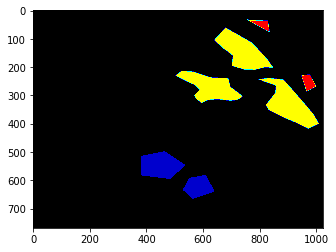

In [ ]:

label_matrix_Level4_1=form_label_matrix(Level4_1_img,"Level4-1",df,1)


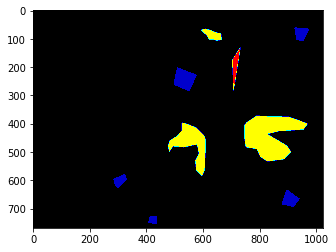

In [ ]:
label_matrix_Level4_3=form_label_matrix(Level4_3_img,"Level4-3",df,1)

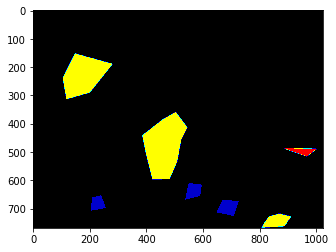

In [ ]:
label_matrix_Level4_4=form_label_matrix(Level4_4_img,"Level4-4",df,1)

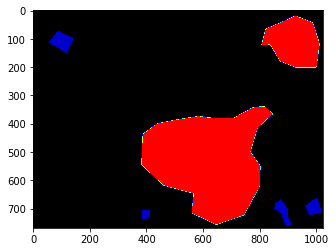

In [ ]:
label_matrix_Level4_5=form_label_matrix(Level4_5_img,"Level4-5",df,1)

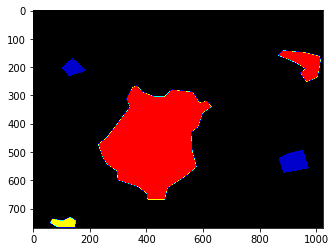

In [ ]:
label_matrix_Level4_6=form_label_matrix(Level4_6_img,"Level4-6",df,1)

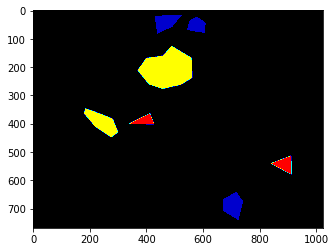

In [ ]:
label_matrix_Level4_7=form_label_matrix(Level4_7_img,"Level4-7",df,1)

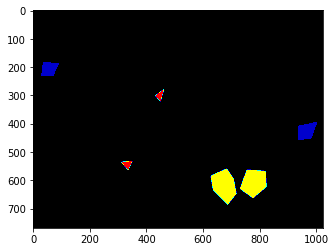

In [ ]:
label_matrix_Level4_8=form_label_matrix(Level4_8_img,"Level4-8",df,1)

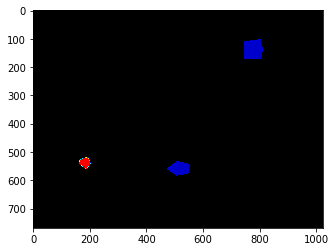

In [ ]:
label_matrix_Level4_9=form_label_matrix(Level4_9_img,"Level4-9",df,1)

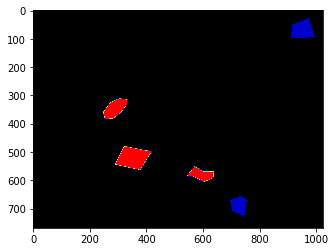

In [ ]:
label_matrix_Level4_10=form_label_matrix(Level4_10_img,"Level4-10",df,1)

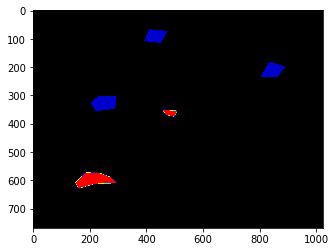

In [ ]:
label_matrix_Peeling_1=form_label_matrix(Peeling_1_img,"Peeling-1",df,1)

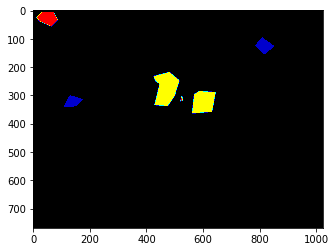

In [ ]:
label_matrix_Peeling_2=form_label_matrix(Peeling_2_img,"Peeling-2",df,1)

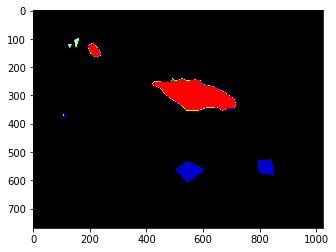

In [ ]:
label_matrix_Peeling_4=form_label_matrix(Peeling_4_img,"Peeling-4",df,1)

## clipping

In [ ]:
def flat_label_matrix(label_matrix):
  label_matrix_flat=label_matrix.reshape( (label_matrix.shape[0]*label_matrix.shape[1],1) )
  return label_matrix_flat


In [ ]:
# flat label matrix 
label_matrix_Level4_1_flat=flat_label_matrix(label_matrix_Level4_1)
label_matrix_Level4_3_flat=flat_label_matrix(label_matrix_Level4_3)
label_matrix_Level4_4_flat=flat_label_matrix(label_matrix_Level4_4)
label_matrix_Level4_5_flat=flat_label_matrix(label_matrix_Level4_5)
label_matrix_Level4_6_flat=flat_label_matrix(label_matrix_Level4_6)
label_matrix_Level4_7_flat=flat_label_matrix(label_matrix_Level4_7)
label_matrix_Level4_8_flat=flat_label_matrix(label_matrix_Level4_8)
label_matrix_Level4_9_flat=flat_label_matrix(label_matrix_Level4_9)
label_matrix_Level4_10_flat=flat_label_matrix(label_matrix_Level4_10)

label_matrix_Peeling_1_flat=flat_label_matrix(label_matrix_Peeling_1)
label_matrix_Peeling_2_flat=flat_label_matrix(label_matrix_Peeling_2)

label_matrix_Peeling_4_flat=flat_label_matrix(label_matrix_Peeling_4)



In [ ]:
# remove rows with zero index 
def generate_X_y(img_refl_input,label_matrix_flat):

  index0_list=np.where(label_matrix_flat==0)[0].tolist()
  y_img=np.delete(label_matrix_flat,index0_list,axis=0)
  X_img=np.delete(img_refl_input,index0_list,axis=0)
  

  return X_img,y_img






In [ ]:
X_img_Level4_1,y_img_Level4_1=generate_X_y( Level4_1_img_refl_input , label_matrix_Level4_1_flat )
X_img_Level4_3,y_img_Level4_3=generate_X_y( Level4_3_img_refl_input , label_matrix_Level4_3_flat )
X_img_Level4_4,y_img_Level4_4=generate_X_y( Level4_4_img_refl_input , label_matrix_Level4_4_flat )
X_img_Level4_5,y_img_Level4_5=generate_X_y( Level4_5_img_refl_input , label_matrix_Level4_5_flat )
X_img_Level4_6,y_img_Level4_6=generate_X_y( Level4_6_img_refl_input , label_matrix_Level4_6_flat )
X_img_Level4_7,y_img_Level4_7=generate_X_y( Level4_7_img_refl_input , label_matrix_Level4_7_flat )
X_img_Level4_8,y_img_Level4_8=generate_X_y( Level4_8_img_refl_input , label_matrix_Level4_8_flat )
X_img_Level4_9,y_img_Level4_9=generate_X_y( Level4_9_img_refl_input , label_matrix_Level4_9_flat )
X_img_Level4_10,y_img_Level4_10=generate_X_y( Level4_10_img_refl_input , label_matrix_Level4_10_flat )


X_img_Peeling_1,y_img_Peeling_1=generate_X_y( Peeling_1_img_refl_input , label_matrix_Peeling_1_flat )
X_img_Peeling_2,y_img_Peeling_2=generate_X_y( Peeling_2_img_refl_input , label_matrix_Peeling_2_flat )

X_img_Peeling_4,y_img_Peeling_4=generate_X_y( Peeling_4_img_refl_input , label_matrix_Peeling_4_flat )

In [ ]:
# concatinate 
X = np.concatenate((X_img_Level4_1,X_img_Level4_3,X_img_Level4_4,X_img_Level4_5,X_img_Level4_6,X_img_Level4_7,X_img_Level4_8,X_img_Level4_9,X_img_Level4_10,X_img_Peeling_1,X_img_Peeling_2,X_img_Peeling_4),0)
#concatinate triplets
y = np.concatenate((y_img_Level4_1,y_img_Level4_3,y_img_Level4_4,y_img_Level4_5,y_img_Level4_6,y_img_Level4_7,y_img_Level4_8,y_img_Level4_9,y_img_Level4_10,y_img_Peeling_1,y_img_Peeling_2,y_img_Peeling_4),0)

In [ ]:
#shuffel 
## shuffle 
def my_shuff(X,y):
  X_shuf=np.zeros(X.shape)
  y_shuf=np.zeros(y.shape)

  arr = np.arange(len(y))
  np.random.shuffle(arr)
  counter=0

  for i in arr:
    X_shuf[counter,:]=X[i,:]
    y_shuf[counter]=y[i]
    counter=counter+1;
  
  return X_shuf,y_shuf


In [ ]:
#shuffel
X_shuf,y_shuf=my_shuff(X,y)
X_shuf,y_shuf=my_shuff(X_shuf,y_shuf)
X_shuf,y_shuf=my_shuff(X_shuf,y_shuf)

In [ ]:
# data split 
X_train, X_test, y_train, y_test=splitTrainTestSet(X_shuf,y_shuf, testRatio=0.1, randomState=345) 

# training

In [ ]:
#train a smaller model for spectral only 
K=X_train.shape[1]
model = Sequential([
    Dense(units=128, input_shape=(K,), activation='relu'), #was 30 # added 128 rather than 64
        
    Dense(units=64, activation='relu',bias_regularizer=l2(0.01)), # %%%%%%%%%%%%%%%%%%%%% added this
    Dense(units=32, activation='relu',bias_regularizer=l2(0.01)),
    Dense(units=16, activation='relu',bias_regularizer=l2(0.01)),
    #Dropout(0.2),    
    Dense(units=4, activation='softmax') # change to right classssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss 
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy']) #reviw  0.0001
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               8192      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 4)                 68        
                                                                 
Total params: 19,124
Trainable params: 19,124
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(
      x=X_train
    , y=y_train - 1 # pay attention in following steps 
    , validation_split=0.1
    , batch_size=10
    , epochs=50
    , verbose=2
)

Epoch 1/50
48534/48534 - 84s - loss: 0.0304 - accuracy: 0.9884 - val_loss: 0.0366 - val_accuracy: 0.9852 - 84s/epoch - 2ms/step
Epoch 2/50
48534/48534 - 83s - loss: 0.0246 - accuracy: 0.9906 - val_loss: 0.0202 - val_accuracy: 0.9924 - 83s/epoch - 2ms/step
Epoch 3/50
48534/48534 - 78s - loss: 0.0213 - accuracy: 0.9920 - val_loss: 0.0208 - val_accuracy: 0.9923 - 78s/epoch - 2ms/step
Epoch 4/50
48534/48534 - 78s - loss: 0.0194 - accuracy: 0.9927 - val_loss: 0.0157 - val_accuracy: 0.9948 - 78s/epoch - 2ms/step
Epoch 5/50
48534/48534 - 82s - loss: 0.0184 - accuracy: 0.9932 - val_loss: 0.0152 - val_accuracy: 0.9948 - 82s/epoch - 2ms/step
Epoch 6/50
48534/48534 - 83s - loss: 0.0176 - accuracy: 0.9935 - val_loss: 0.0139 - val_accuracy: 0.9954 - 83s/epoch - 2ms/step
Epoch 7/50
48534/48534 - 78s - loss: 0.0167 - accuracy: 0.9938 - val_loss: 0.0142 - val_accuracy: 0.9951 - 78s/epoch - 2ms/step
Epoch 8/50
48534/48534 - 82s - loss: 0.0159 - accuracy: 0.9941 - val_loss: 0.0122 - val_accuracy: 0.9957

#save model

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('DNN_sydney_shortrange_mypreprocessing_spsp_50epochs')

INFO:tensorflow:Assets written to: DNN_sydney_shortrange_mypreprocessing_spsp_50epochs/assets


# Testing

# on test dataset 

In [ ]:

model_short=keras.models.load_model('/content/drive/MyDrive/DNN_sydney_shortrange_mypreprocessing_spsp_50epochs')

In [ ]:

predictions = model_short.predict(
      #x=scaled_samples_withoutzero
      x=X_test #X_test      
    , batch_size=1000 # what is the defualt
    , verbose=0
)  

rounded_predictions = np.argmax(predictions, axis=-1) #review the axis


target_names = ['Level 1','Level 3','Level 4','background']
print( classification_report( y_test - 1 , rounded_predictions,target_names=target_names ) )


              precision    recall  f1-score   support

     Level 1       1.00      1.00      1.00     11016
     Level 3       0.93      0.99      0.96      1619
     Level 4       1.00      1.00      1.00     46049
  background       0.99      1.00      1.00      1235

    accuracy                           1.00     59919
   macro avg       0.98      1.00      0.99     59919
weighted avg       1.00      1.00      1.00     59919



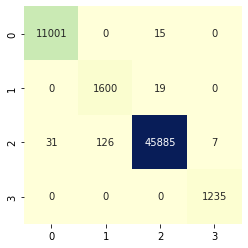

In [ ]:
import seaborn as sns
matrix_confusion = confusion_matrix(y_test-1, rounded_predictions)
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='YlGnBu', fmt='d', cbar=False)

## on Images

In [ ]:
draw=1

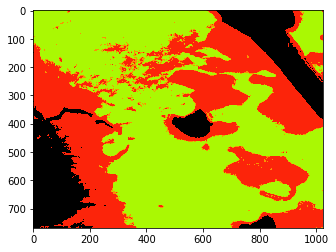

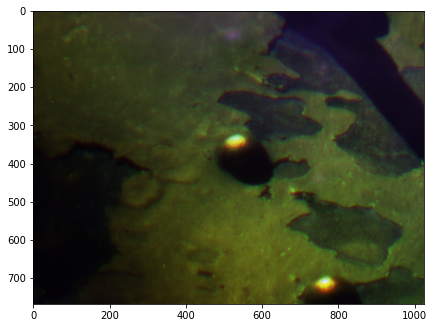

In [ ]:
predict_image(Level4_1_img,draw)

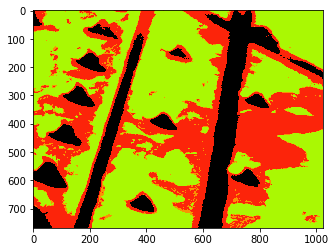

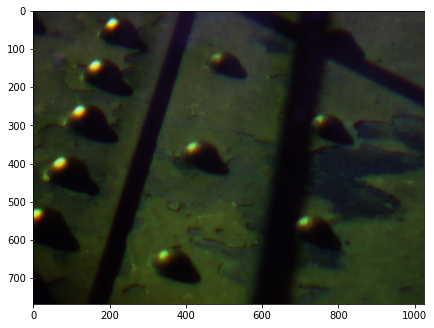

In [ ]:
predict_image(Level4_3_img,draw)

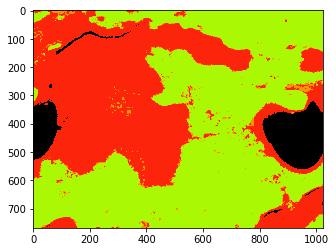

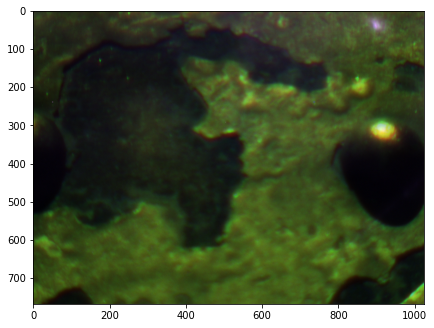

In [ ]:
predict_image(Level4_4_img,draw)

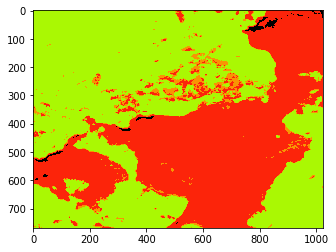

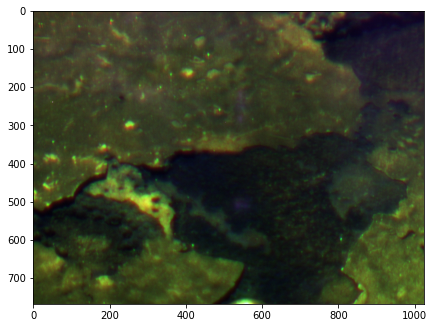

In [ ]:
predict_image(Level4_5_img,draw)

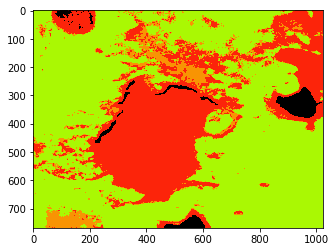

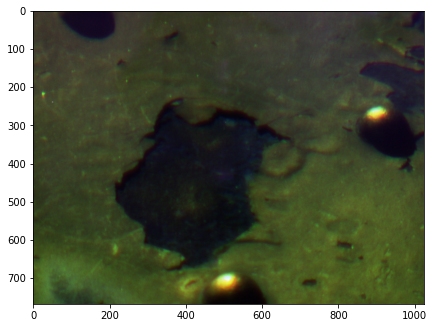

In [ ]:
predict_image(Level4_6_img,draw)

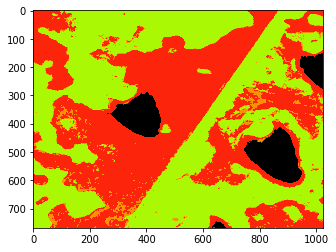

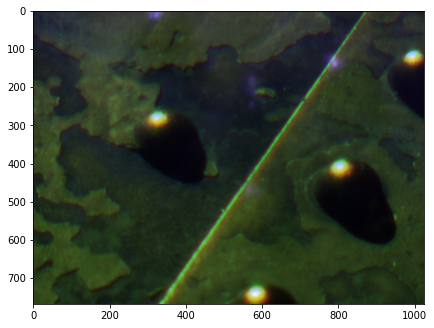

In [ ]:
predict_image(Level4_7_img,draw)

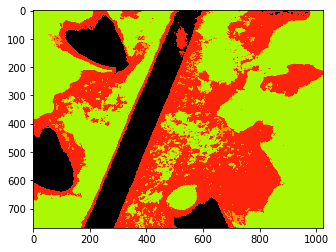

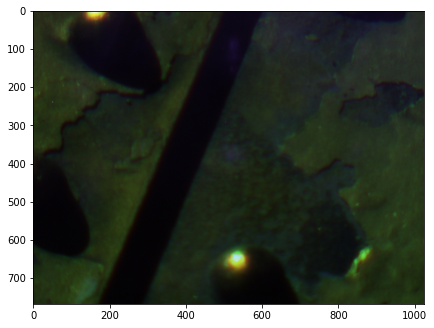

In [ ]:
predict_image(Level4_8_img,draw)

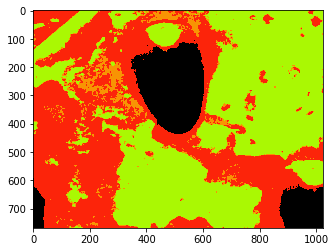

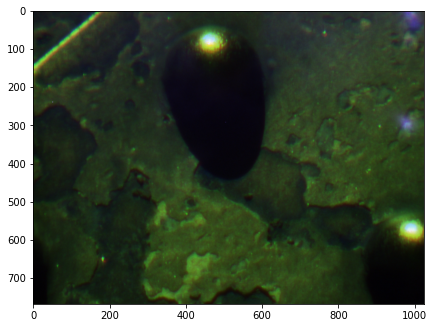

In [ ]:
predict_image(Level4_9_img,draw)

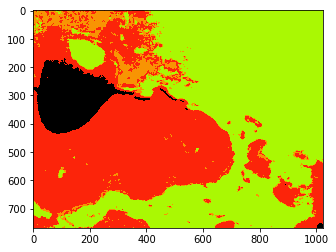

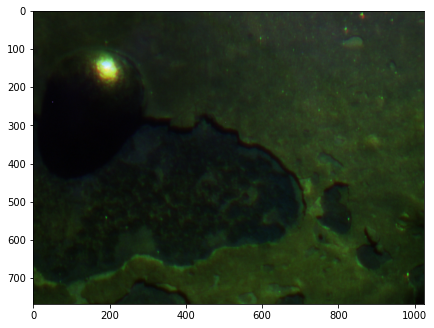

In [ ]:
predict_image(Level4_10_img,draw)

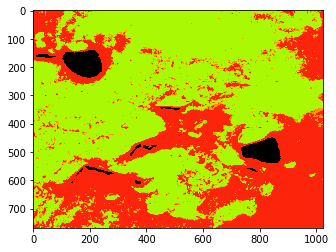

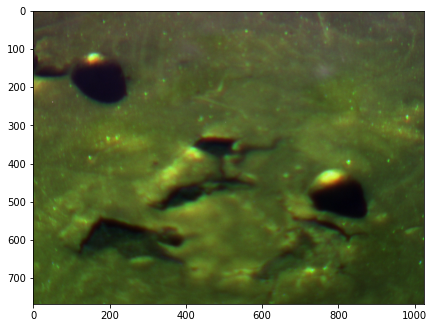

In [ ]:
predict_image(Peeling_1_img,draw)

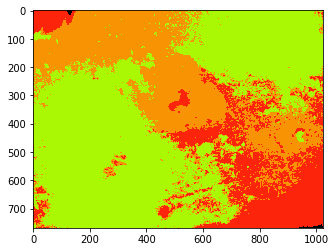

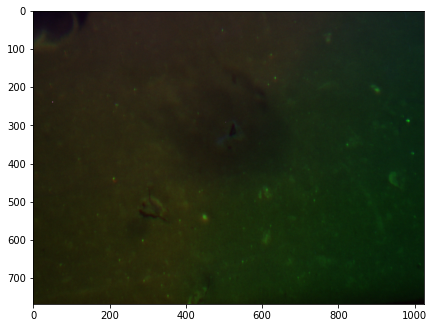

In [ ]:
predict_image(Peeling_2_img,draw)

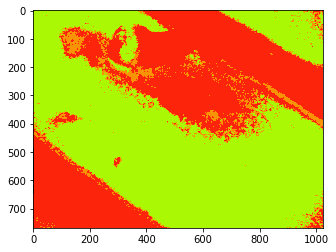

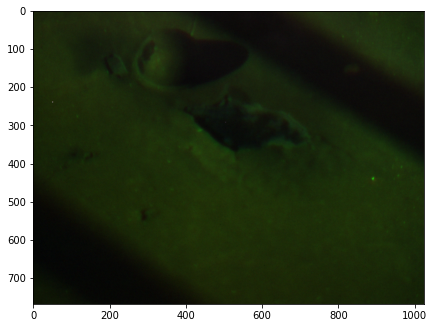

In [ ]:
predict_image(Peeling_4_img,draw)

# inference speed

In [ ]:
print( Level4_1_img.shape[0]*Level4_1_img.shape[1] )

786432


In [ ]:
import time
number_pixels_image=Level4_1_img.shape[0]*Level4_1_img.shape[1]
def predict_and_benchmark_throughput(input, infer, N_warmup_run=10, N_run=100):

  elapsed_time = []



  for i in range(N_warmup_run):
      predictions = model_short.predict(
            #x=scaled_samples_withoutzero
            x=input #X_test      
          , batch_size=1000 # what is the defualt
          , verbose=0)
      

  for i in range(N_run):
    start_time = time.time()

    predictions = model_short.predict(
      #x=scaled_samples_withoutzero
      x=input #X_test      
    , batch_size=1000 # what is the defualt
    , verbose=0 )
     


    end_time = time.time()

    elapsed_time = np.append(elapsed_time, end_time - start_time)
    
  

    if i % 50 == 0:
      print('Steps {}-{} average: {:4.1f}ms'.format(i, i+50, (elapsed_time[-50:].mean()) * 1000))

  print('Throughput: {:.0f} pixels/s'.format(input.shape[0] / elapsed_time.mean()))
  print(f' an image of size {number_pixels_image} will take {number_pixels_image / (input.shape[0] / elapsed_time.mean())}')

In [ ]:
pred=predict_and_benchmark_throughput(X_shuf, model_short, N_warmup_run=10, N_run=2)

Steps 0-50 average: 1548.7ms
Throughput: 286223 pixels/s
 an image of size 786432 will take 225094714259.87604


## non predict way

In [ ]:
model_short.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               8192      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 4)                 68        
                                                                 
Total params: 19,124
Trainable params: 19,124
Non-trainable params: 0
_________________________________________________________________


In [ ]:
N_batch=1000
batched_input=X_shuf[0:N_batch]
print(batched_input.shape)

(1000, 63)


In [ ]:
import time
def predict_and_benchmark_throughput(batched_input, infer, N_warmup_run=10, N_run=100):

  elapsed_time = []
  all_preds = []
  batch_size = batched_input.shape[0] 

  tensor_list = tf.convert_to_tensor(batched_input) # change to tensor
  tensor_list = tf.cast(tensor_list, tf.float32)  # change to float32

  for i in range(N_warmup_run):
    labeling = infer(tensor_list)
    #preds = labeling['dense_4'].numpy()

  for i in range(N_run):
    start_time = time.time()

    labeling = infer(tensor_list)

    #preds = labeling['dense_4'].numpy()

    end_time = time.time()

    elapsed_time = np.append(elapsed_time, end_time - start_time)
    
    #all_preds.append(preds)

    if i % 50 == 0:
      print('Steps {}-{} average: {:4.1f}ms'.format(i, i+50, (elapsed_time[-50:].mean()) * 1000))

  print('Throughput: {:.0f} pixels/s'.format(N_run * batch_size / elapsed_time.sum()))
  #return all_preds

In [ ]:
 predict_and_benchmark_throughput( batched_input, model_short, N_warmup_run=10 , N_run=500 )

Steps 0-50 average:  8.1ms
Steps 50-100 average:  7.3ms
Steps 100-150 average:  7.4ms
Steps 150-200 average: 13.4ms
Steps 200-250 average: 13.1ms
Steps 250-300 average: 13.0ms
Steps 300-350 average: 11.9ms
Steps 350-400 average: 14.4ms
Steps 400-450 average: 12.7ms
Steps 450-500 average:  9.7ms
Throughput: 83665 pixels/s


# preprocessing speed for one image

In [ ]:
import time 

elapsed_time=[]

for step in range(10):

  start_time = time.time()

  Level4_1_img_refl_input=change_2_triple_input(Level4_1_img_refl)

  end_time=time.time()

  elapsed_time = np.append(elapsed_time, end_time - start_time)

average_time=elapsed_time.mean()
print(average_time)

1.3715696573257445
